<a href="https://colab.research.google.com/github/Dewdiii/Forecasting-Industry-Growth-Based-on-Historical-Trade-Data-Exports-Imports-in-Sri-Lanka./blob/main/ImpExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import os, pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [30]:
from google.colab import files
uploaded = files.upload()  # Choose ImpExp.zip

Saving ImpExp.zip to ImpExp (2).zip


In [31]:
import zipfile
import os

with zipfile.ZipFile("ImpExp.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")  # extracts to data/ImpExp/

In [32]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

## Build the Dataset

In [33]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_industry_data(industry):
    all_csvs = os.listdir(data_dir.format(industry))
    all_csvs = [f for f in all_csvs if f.endswith(".xlsx")]
    all_csv_paths = [os.path.join(data_dir.format(industry), f) for f in all_csvs]

    all_data = []
    for csv in all_csv_paths:
        df = pd.read_excel(csv, sheet_name='Partner')
        df['Partner Name'] = df['Partner Name'].str.strip()
        df = df[df['Partner Name'] == 'World']
        assert len(df) == 1, f"More than one or no 'World' data found in {csv}"

        df = df[[
            'Year',
            'Export (US$ Thousand)',      # index 0 (Y1)
            'Import (US$ Thousand)',      # index 1 (Y2)
            'Revealed comparative advantage',
            'World Growth (%)',
            'Country Growth (%)',
            'AHS Simple Average (%)',
            'AHS Dutiable Tariff Lines Share (%)',
        ]]
        df.reset_index(drop=True, inplace=True)
        all_data.append(df)

    all_data = pd.concat(all_data).reset_index(drop=True)
    all_data.fillna(all_data.mean(), inplace=True)
    all_data = all_data.astype(float)
    all_data.sort_values(by='Year', inplace=True)

    # Separate columns
    targets = all_data[['Export (US$ Thousand)', 'Import (US$ Thousand)']].copy()
    features = all_data.drop(columns=['Year', 'Export (US$ Thousand)', 'Import (US$ Thousand)'])

    # Scale targets separately
    scaler_Y1 = StandardScaler()
    scaler_Y2 = StandardScaler()

    Y1_scaled = scaler_Y1.fit_transform(targets[['Export (US$ Thousand)']])
    Y2_scaled = scaler_Y2.fit_transform(targets[['Import (US$ Thousand)']])

    # Scale features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(features)

    # Save scalers
    os.makedirs(os.path.dirname(model_dir.format("")), exist_ok=True)
    pickle.dump(scaler_X, open(model_dir.format(f"{industry} XScalar.pickle"), 'wb'))
    pickle.dump(scaler_Y1, open(model_dir.format(f"{industry} Y1Scalar.pickle"), 'wb'))
    pickle.dump(scaler_Y2, open(model_dir.format(f"{industry} Y2Scalar.pickle"), 'wb'))

    # Combine back into one DataFrame with scaled data
    scaled_df = pd.DataFrame(
        np.concatenate([Y1_scaled, Y2_scaled, X_scaled], axis=1),
        columns=[
            'Export (US$ Thousand)',
            'Import (US$ Thousand)',
            'Revealed comparative advantage',
            'World Growth (%)',
            'Country Growth (%)',
            'AHS Simple Average (%)',
            'AHS Dutiable Tariff Lines Share (%)'
        ]
    )

    return scaled_df

def make_ts_dataset(industry, selective_window=7):
    df = load_industry_data(industry)

    X, Y1, Y2 = [], [], []
    for i in range(len(df) - selective_window):
        x = df.iloc[i:i+selective_window].values
        y1 = df.iloc[i+selective_window, 0]  # Scaled Export
        y2 = df.iloc[i+selective_window, 1]  # Scaled Import

        X.append(x)
        Y1.append(y1)
        Y2.append(y2)

    return np.array(X), np.array(Y1), np.array(Y2)

### Load Sample Data

In [34]:
X, Y1, Y2 = make_ts_dataset('Agricultural Raw Materials')

print("World Data Shape : ", X.shape)
print("Export Data Shape : ", Y1.shape)
print("Import Data Shape : ", Y2.shape)

World Data Shape :  (9, 7, 7)
Export Data Shape :  (9,)
Import Data Shape :  (9,)


# Baseline Models

In [35]:
import numpy as np
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_growth_rate(predicted, last_actual):
    if last_actual == 0:
        return 0
    return ((predicted - last_actual) / last_actual) * 100

def baseline_training_evaluation(industry, window_size=3):
    # Load data and scaler
    df = load_industry_data(industry)  # assumed shape: [time_steps, 2] with columns [export, import]
    scaler = pickle.load(open(model_dir.format(f"{industry} Scalar.pickle"), 'rb'))

    # Undo scaling
    df_inv = scaler.inverse_transform(df)

    # Separate export and import series
    export_series = df_inv[:, 0]
    import_series = df_inv[:, 1]

    def evaluate_series(series, label):
        print(f"\n--- {label} ---")

        # Naive predictions: previous year's value (shifted by 1)
        naive_preds = series[:-1]
        naive_actuals = series[1:]

        # SMA predictions (window_size)
        sma_preds = []
        sma_actuals = []
        for i in range(window_size, len(series)):
            window = series[i - window_size:i]
            sma_preds.append(np.mean(window))
            sma_actuals.append(series[i])

        # --- Naive Metrics ---
        naive_mae = mean_absolute_error(naive_actuals, naive_preds)
        naive_mse = mean_squared_error(naive_actuals, naive_preds)
        naive_rmse = np.sqrt(naive_mse)
        naive_mean_actual = np.mean(np.abs(naive_actuals))
        naive_mape = (naive_mae / naive_mean_actual) * 100
        naive_acc = 100 - naive_mape

        # --- SMA Metrics ---
        sma_mae = mean_absolute_error(sma_actuals, sma_preds)
        sma_mse = mean_squared_error(sma_actuals, sma_preds)
        sma_rmse = np.sqrt(sma_mse)
        sma_mean_actual = np.mean(np.abs(sma_actuals))
        sma_mape = (sma_mae / sma_mean_actual) * 100
        sma_acc = 100 - sma_mape

        # Print results
        print("Naïve Accuracy:")
        print(f"  MAE:  {naive_mae:.2f}")
        print(f"  MSE:  {naive_mse:.2f}")
        print(f"  RMSE: {naive_rmse:.2f}")
        print(f"  MAPE: {naive_mape:.2f}%")
        print(f"  Accuracy: {naive_acc:.2f}%")

        print("SMA Accuracy:")
        print(f"  MAE:  {sma_mae:.2f}")
        print(f"  MSE:  {sma_mse:.2f}")
        print(f"  RMSE: {sma_rmse:.2f}")
        print(f"  MAPE: {sma_mape:.2f}%")
        print(f"  Accuracy: {sma_acc:.2f}%")

        # Growth rate prediction
        last_actual = series[-2]  # second last actual value
        naive_pred = series[-2]   # naive = previous actual
        sma_pred = np.mean(series[-window_size - 1:-1])  # SMA window before last known

        naive_growth = get_growth_rate(naive_pred, last_actual)
        sma_growth = get_growth_rate(sma_pred, last_actual)

        print(f"Naive Predicted Growth: {naive_growth:.2f}%")
        print(f"SMA Predicted Growth:   {sma_growth:.2f}%")

    print(f"\n Baseline Training Evaluation for Industry: {industry} (window={window_size})")

    evaluate_series(export_series, "Export")
    evaluate_series(import_series, "Import")

In [36]:
baseline_training_evaluation('Agricultural Raw Materials', window_size=3)


 Baseline Training Evaluation for Industry: Agricultural Raw Materials (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  45766.05
  MSE:  2952697504.69
  RMSE: 54338.73
  MAPE: 15.91%
  Accuracy: 84.09%
SMA Accuracy:
  MAE:  55336.34
  MSE:  4631915570.28
  RMSE: 68058.18
  MAPE: 18.17%
  Accuracy: 81.83%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   -10.98%

--- Import ---
Naïve Accuracy:
  MAE:  53988.11
  MSE:  4708589783.71
  RMSE: 68619.16
  MAPE: 21.87%
  Accuracy: 78.13%
SMA Accuracy:
  MAE:  72405.66
  MSE:  7534516973.21
  RMSE: 86801.60
  MAPE: 27.58%
  Accuracy: 72.42%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   10.05%


In [37]:
baseline_training_evaluation('Consumer Goods', window_size=3)


 Baseline Training Evaluation for Industry: Consumer Goods (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  720244.59
  MSE:  674797320163.76
  RMSE: 821460.48
  MAPE: 9.55%
  Accuracy: 90.45%
SMA Accuracy:
  MAE:  748797.27
  MSE:  783966067576.76
  RMSE: 885418.58
  MAPE: 9.47%
  Accuracy: 90.53%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   6.09%

--- Import ---
Naïve Accuracy:
  MAE:  947863.18
  MSE:  1247659704340.62
  RMSE: 1116986.89
  MAPE: 19.17%
  Accuracy: 80.83%
SMA Accuracy:
  MAE:  866368.67
  MSE:  1284660347203.94
  RMSE: 1133428.58
  MAPE: 16.43%
  Accuracy: 83.57%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   29.17%


In [38]:
baseline_training_evaluation('Transportation', window_size=3)


 Baseline Training Evaluation for Industry: Transportation (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  75888.57
  MSE:  9614073131.04
  RMSE: 98051.38
  MAPE: 37.46%
  Accuracy: 62.54%
SMA Accuracy:
  MAE:  69039.73
  MSE:  7272176443.70
  RMSE: 85277.06
  MAPE: 32.63%
  Accuracy: 67.37%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   68.87%

--- Import ---
Naïve Accuracy:
  MAE:  435642.24
  MSE:  289278875556.66
  RMSE: 537846.52
  MAPE: 32.51%
  Accuracy: 67.49%
SMA Accuracy:
  MAE:  525376.91
  MSE:  474184422661.87
  RMSE: 688610.50
  MAPE: 36.58%
  Accuracy: 63.42%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   105.31%


In [39]:
baseline_training_evaluation('Food Industry', window_size=3)


 Baseline Training Evaluation for Industry: Food Industry (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  48799.68
  MSE:  5101659887.93
  RMSE: 71425.90
  MAPE: 13.01%
  Accuracy: 86.99%
SMA Accuracy:
  MAE:  80596.02
  MSE:  9853026810.03
  RMSE: 99262.41
  MAPE: 19.74%
  Accuracy: 80.26%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   -6.08%

--- Import ---
Naïve Accuracy:
  MAE:  79635.03
  MSE:  9497381160.02
  RMSE: 97454.51
  MAPE: 11.47%
  Accuracy: 88.53%
SMA Accuracy:
  MAE:  105556.13
  MSE:  17843026389.15
  RMSE: 133577.79
  MAPE: 14.26%
  Accuracy: 85.74%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   1.83%


In [40]:
baseline_training_evaluation('Capital Goods', window_size=3)


 Baseline Training Evaluation for Industry: Capital Goods (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  115110.24
  MSE:  17204406277.59
  RMSE: 131165.57
  MAPE: 23.75%
  Accuracy: 76.25%
SMA Accuracy:
  MAE:  85173.19
  MSE:  11061014503.30
  RMSE: 105171.36
  MAPE: 16.75%
  Accuracy: 83.25%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   20.15%

--- Import ---
Naïve Accuracy:
  MAE:  514694.04
  MSE:  424135416045.69
  RMSE: 651256.80
  MAPE: 16.85%
  Accuracy: 83.15%
SMA Accuracy:
  MAE:  660718.50
  MSE:  642839778910.31
  RMSE: 801772.90
  MAPE: 20.36%
  Accuracy: 79.64%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   23.49%


## Build, Train, Evaluate model

In [41]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle

def build_ts_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(128, return_sequences=True),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=['mae']
    )
    return model

def calculate_mape_and_accuracy(mae, Y_scaled, scaler):
    """
    Converts scaled MAE back to original scale using StandardScaler
    and calculates MAPE and accuracy.
    """
    # Inverse transform actual target values
    Y_original = scaler.inverse_transform(Y_scaled.reshape(-1, 1)).flatten()

    # Convert MAE from scaled to original values
    mae_original = mae * scaler.scale_[0]  # Standard deviation

    # MAPE = Mean Absolute Percentage Error
    mean_actual = np.mean(np.abs(Y_original))
    mape = (mae_original / mean_actual) * 100
    accuracy = 100 - mape

    return mape, accuracy, mae_original


def train_ts_model(industry, epochs=100, batch_size=4):
    X, Y1, Y2 = make_ts_dataset(industry)

    print(f"................ Training on : {industry} ................")
    model_imp = build_ts_model()
    model_exp = build_ts_model()

    history_imp = model_imp.fit(
        X, Y1,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    history_exp = model_exp.fit(
        X, Y2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    model_imp.save(model_dir.format(f"{industry} Imp.h5"))
    model_exp.save(model_dir.format(f"{industry} Exp.h5"))

    # Load the correct scalers for Y1 and Y2
    scaler_Y1 = pickle.load(open(model_dir.format(f"{industry} Y1Scalar.pickle"), 'rb'))
    scaler_Y2 = pickle.load(open(model_dir.format(f"{industry} Y2Scalar.pickle"), 'rb'))

    # Get last epoch MAEs (on scaled data)
    mae_imp = history_imp.history['mae'][-1]
    mae_exp = history_exp.history['mae'][-1]

    # Convert MAE to real scale and calculate accuracy
    mape_imp, acc_imp, real_mae_imp = calculate_mape_and_accuracy(mae_imp, Y1, scaler_Y1)
    mape_exp, acc_exp, real_mae_exp = calculate_mape_and_accuracy(mae_exp, Y2, scaler_Y2)

    print(f"\n==== Accuracy Report for {industry} ====")
    print(f"Import MAE (real): {real_mae_imp:,.2f} | MAPE: {mape_imp:.2f}% | Accuracy: {acc_imp:.2f}%")
    print(f"Export MAE (real): {real_mae_exp:,.2f} | MAPE: {mape_exp:.2f}% | Accuracy: {acc_exp:.2f}%\n")

    return history_imp, history_exp

def plot_loss(industry, history_imp, history_exp):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_exp.history['loss'], label='MSE')
    plt.plot(history_exp.history['mae'], label='MAE')
    plt.title(f"Export Model Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_imp.history['loss'], label='MSE')
    plt.plot(history_imp.history['mae'], label='MAE')
    plt.title(f"Import Model Loss")
    plt.legend()

    plt.suptitle(f"{industry} Model Logs")
    plt.show()

def run_ts_model(industry):
    history_imp, history_exp = train_ts_model(industry)
    plot_loss(industry, history_imp, history_exp)

................ Training on : Agricultural Raw Materials ................



==== Accuracy Report for Agricultural Raw Materials ====
Import MAE (real): 1,501.46 | MAPE: 0.49% | Accuracy: 99.51%
Export MAE (real): 1,194.40 | MAPE: 0.40% | Accuracy: 99.60%



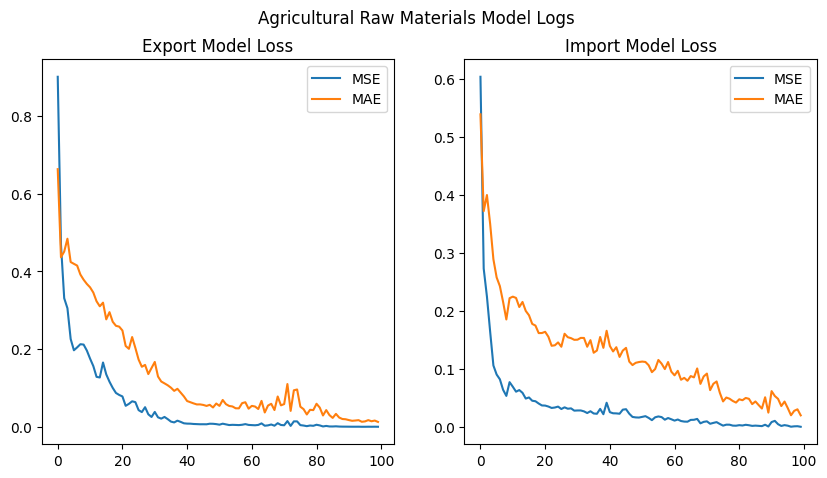

In [42]:
run_ts_model('Agricultural Raw Materials')

................ Training on : Consumer Goods ................



==== Accuracy Report for Consumer Goods ====
Import MAE (real): 7,377.75 | MAPE: 0.09% | Accuracy: 99.91%
Export MAE (real): 18,108.53 | MAPE: 0.31% | Accuracy: 99.69%



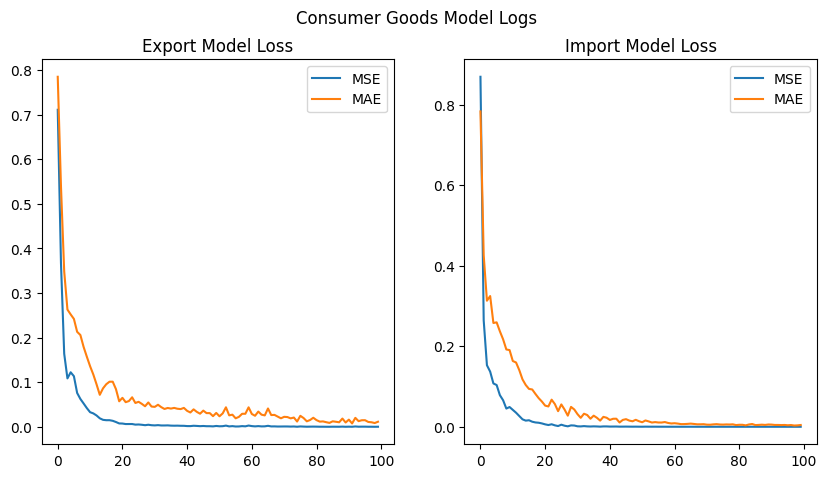

In [43]:
run_ts_model('Consumer Goods')

................ Training on : Transportation ................



==== Accuracy Report for Transportation ====
Import MAE (real): 475.04 | MAPE: 0.20% | Accuracy: 99.80%
Export MAE (real): 73.48 | MAPE: 0.00% | Accuracy: 100.00%



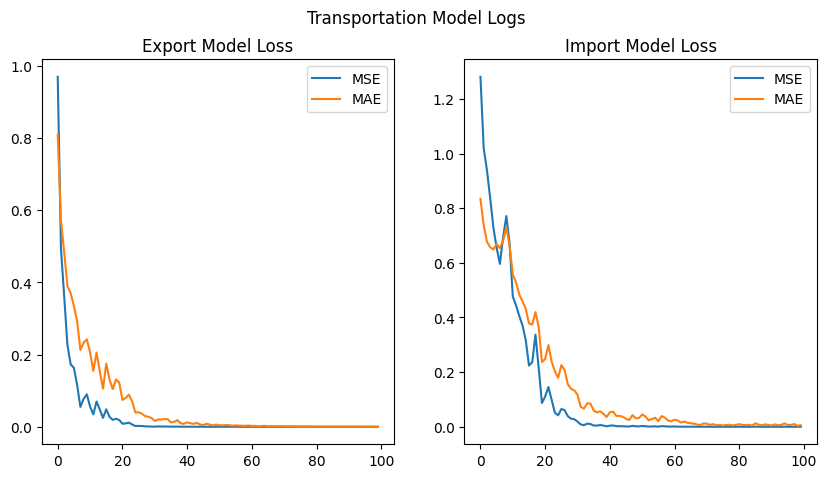

In [44]:
run_ts_model('Transportation')

................ Training on : Food Industry ................



==== Accuracy Report for Food Industry ====
Import MAE (real): 3,409.77 | MAPE: 0.72% | Accuracy: 99.28%
Export MAE (real): 3,347.63 | MAPE: 0.42% | Accuracy: 99.58%



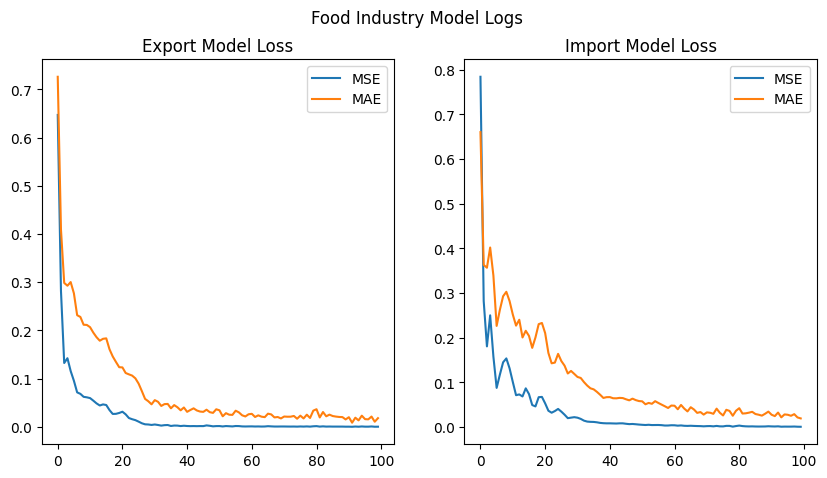

In [45]:
run_ts_model('Food Industry')

................ Training on : Capital Goods ................



==== Accuracy Report for Capital Goods ====
Import MAE (real): 4,565.01 | MAPE: 0.79% | Accuracy: 99.21%
Export MAE (real): 23,002.54 | MAPE: 0.63% | Accuracy: 99.37%



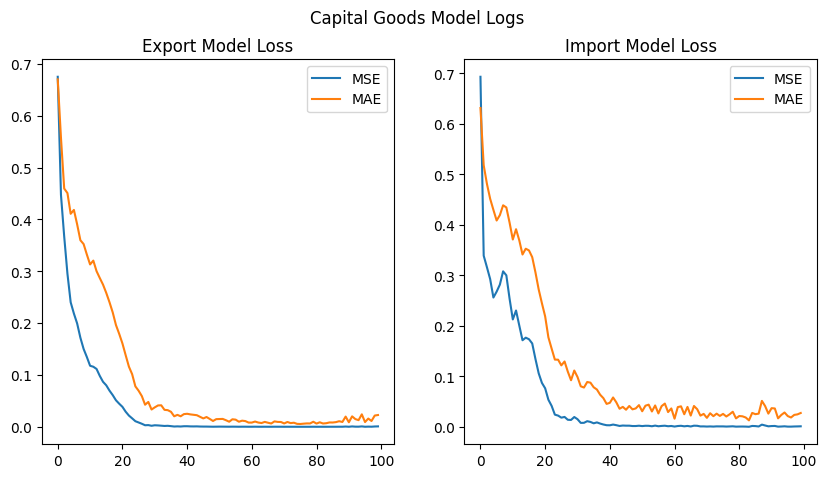

In [46]:
run_ts_model('Capital Goods')

## Inference

In [47]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

model_dict = {}

for industry in industries:
    industry_dict = {}
    industry_dict['Imp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Imp.h5"),
                                                            custom_objects={'mse': 'mse'}
                                                            )
    industry_dict['Exp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Exp.h5"),
                                                            custom_objects={'mse': 'mse'}
                                                            )
    industry_dict['Scaler'] = pickle.load(open(model_dir.format(f"{industry} Scalar.pickle"), 'rb'))

    model_dict[industry] = industry_dict

In [48]:
def predict_ts_on_industry(
                            industry,
                            selective_window=7
                            ):
    industry_dict = model_dict[industry]
    scaler = industry_dict['Scaler']
    imp_model = industry_dict['Imp Model']
    exp_model = industry_dict['Exp Model']

    df = load_industry_data(industry)
    df_tail = df.tail(selective_window)

    x = df_tail.values
    x = x.reshape(1, x.shape[0], x.shape[1])

    p_imp = imp_model.predict(x).squeeze()
    p_imp = np.vstack([p_imp]*selective_window).squeeze()
    p_imp = np.dstack([p_imp]*selective_window).squeeze()
    p_imp = scaler.inverse_transform(p_imp)
    p_imp = p_imp[0][0]

    p_exp = exp_model.predict(x).squeeze()
    p_exp = np.vstack([p_exp]*selective_window).squeeze()
    p_exp = np.dstack([p_exp]*selective_window).squeeze()
    p_exp = scaler.inverse_transform(p_exp)
    p_exp = p_exp[0][0]

    df_tail_inv = scaler.inverse_transform(df_tail)
    imp_data = df_tail_inv[:, 0]
    exp_data = df_tail_inv[:, 1]

    avg_imp = np.mean(imp_data)
    avg_exp = np.mean(exp_data)

    # percentage of change
    p_imp = ((p_imp - avg_imp) / avg_imp) * 100
    p_exp = ((p_exp - avg_exp) / avg_exp) * 100

    return p_imp, p_exp

In [49]:
p_imp, p_exp = predict_ts_on_industry('Agricultural Raw Materials')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
Predicted Export Change : 14.98%
Predicted Import Change : 8.37%


In [50]:
p_imp, p_exp = predict_ts_on_industry('Consumer Goods')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
Predicted Export Change : 32.80%
Predicted Import Change : 9.35%


In [51]:
p_imp, p_exp = predict_ts_on_industry('Transportation')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Predicted Export Change : -93.70%
Predicted Import Change : -30.01%


In [52]:
p_imp, p_exp = predict_ts_on_industry('Food Industry')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
Predicted Export Change : -29.36%
Predicted Import Change : 76.68%


In [53]:
p_imp, p_exp = predict_ts_on_industry('Capital Goods')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Predicted Export Change : -85.16%
Predicted Import Change : -2.68%
